In [10]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress
from matplotlib import cm
from pylab import *
from matplotlib.ticker import ScalarFormatter

In [2]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

def msd_from_gsd(gsdfile, start=-10, stop=-1, atom_type='ss', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

In [3]:
project = signac.get_project("ptb7-project")

In [4]:
state_dict = {'size': 'small', 'process': 'quench', 
              "density": 0.8, "molecule": "PTB7_5mer_smiles"}

job_list = project.find_jobs(state_dict)
for job in job_list:
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    tspf = job.sp['n_steps'] / 100
    y = msd[-15:]
    x = np.arange(0, len(y), 1) * tspf
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    job.doc['msd_slope'] = slope
    job.doc['msd_slope_r2'] = r_value
    print("slope of", job, "is:")
    print(slope)

slope of f53993e769f03f88ae907622563e820d is:
7.344823113916994e-05
slope of 967ae38150f77f26fc3774a0076ea59e is:
3.176175202791891e-05
slope of 6b2674efa6329abc28e375b9dbf81840 is:
4.695014304437832e-06
slope of f2e48e3760cf2c65a3a5e540d857bdfa is:
8.554439116030017e-05
slope of 2733adb9aa821cd2436a9b0dc75b1e2f is:
0.00010938007395923246
slope of 480cf2a072270413758efb6e2c00a611 is:
2.3265504438906994e-06
slope of 230372d489c899de62fe688441ea44b1 is:
0.00011341371635408993
slope of 970c986cbb6d270a87945b300640e00d is:
0.00012275916447296648
slope of 73dca9323b578fb6d98ea75453f516b2 is:
7.055210221623218e-06
slope of d0859f679a2b541ff81392d0458a3bd9 is:
9.487477611195019e-05
slope of 4ec2bd8bf6ba578cc9f26e39ba6f4524 is:
4.186271606369952e-06
slope of 95eb6b57530bc5bb6c89243047a24a06 is:
1.130399952431291e-05
slope of 75ea4012903d3df812808b1e4e44c11c is:
0.00011133204423564531
slope of 659ce11e054e62d31400032303010b70 is:
3.943428677641936e-06
slope of e9ec6ec6584a0e88c79147b9a0e5ab42 i

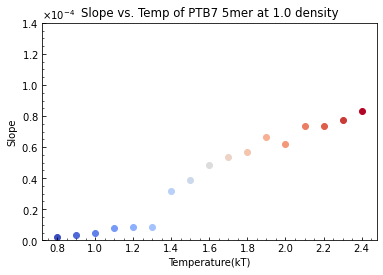

In [9]:
state_dict = {'size': 'small', 'process': 'quench', "density": 1.0, "molecule":"PTB7_5mer_smiles" }
job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
state_dict['kT_reduced.$lt'] = 2.5
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))

mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

for temp,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    slope = job.doc['msd_slope']
    x2=job.sp["kT_reduced"]
    y2=slope
    plt.ylim(0, 0.00014)
    plt.scatter(x2,y2, label=temp)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    
if job.sp['molecule'] == "PTB7_5mer_smiles":
    mol = "5mer"
if job.sp['molecule'] == "PTB7_10mer_smiles":
    mol = "10mer"
if job.sp['molecule'] == "PTB7_15mer_smiles":
    mol = "15mer"
plt.title("Slope vs. Temp of PTB7 %s at %s density" % (mol, job.sp['density']), fontsize=11.75 )
plt.xlabel("Temperature(kT)")
plt.ylabel("Slope")
plt.show()

In [11]:
def make_me_a_graph(state_dict):
    
    state_dict = {'size': 'small', 'process': 'quench', "density": 1.0, "molecule":"PTB7_5mer_smiles" }
    job_list = project.find_jobs(state_dict)
    fig = plt.figure()
    ax = plt.subplot(111)
    state_dict['kT_reduced.$lt'] = 2.5
    color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))

    mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

    for temp,job in job_list.groupby('kT_reduced'):
        job = list(job)[0]
        msd = msd_from_gsd(job.fn('trajectory.gsd'))
        slope = job.doc['msd_slope']
        x2=job.sp["kT_reduced"]
        y2=slope
        plt.ylim(0, 0.00014)
        plt.scatter(x2,y2, label=temp)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

    if job.sp['molecule'] == "PTB7_5mer_smiles":
        mol = "5mer"
    if job.sp['molecule'] == "PTB7_10mer_smiles":
        mol = "10mer"
    if job.sp['molecule'] == "PTB7_15mer_smiles":
        mol = "15mer"
    plt.title("Slope vs. Temp of PTB7 %s at %s density" % (mol, job.sp['density']), fontsize=11.75 )
    plt.xlabel("Temperature(kT)")
    plt.ylabel("Slope")
    plt.show() 
    

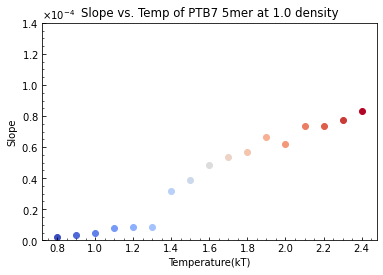

In [13]:
make_me_a_graph(state_dict = {'size': 'small', 'process': 'quench', 
                              "density": 1.2, "molecule":"PTB7_5mer_smiles" })

In [ ]:
#project = signac.get_project("ptb7-project")
#
#state_dict = {'size': 'small', 'process': 'quench', 
#              "density": 1.0, "molecule": "PTB7_15mer_smiles"}
#
#job_list = project.find_jobs(state_dict)
#   
#for job in job_list:
#    msd = msd_from_gsd(job.fn('trajectory.gsd'))
#    slope = job.doc['msd_slope']
#    x2=job.sp["kT_reduced"]
#    y2=slope
#    if x2 == 0.8: 
#        col = ['#00004c']
#    if x2 == 0.9: 
#        col = ['#000079']
#    if x2 == 1.0: 
#        col = ['#0000a6']
#    if x2 == 1.1: 
#        col = ['#0000d2']
#    if x2 == 1.2: 
#        col = ['#0000ff']
#    if x2 == 1.3: 
#        col = ['#4040ff']
#    if x2 == 1.4: 
#        col = ['#8080ff']
#    if x2 == 1.5: 
#        col = ['#bfbfff']
#    if x2 == 1.6: 
#        col = ['#dbd9d9']
#    if x2 == 1.7: 
#        col = ['#ffbfbf']
#    if x2 == 1.8: 
#        col = ['#ff8080']
#    if x2 == 1.9: 
#        col = ['#ff4040']
#    if x2 == 2.0: 
#        col = ['#ff0000']
#    if x2 == 2.1: 
#        col = ['#df0000']
#    if x2 == 2.2: 
#        col = ['#bf0000']
#    if x2 == 2.3: 
#        col = ['#9f0000']
#    if x2 == 2.4: 
#        col = ['#800000']
#    #plt.ylim(0, 35.0)
#    plt.scatter(x2,y2, color = col)#, label=slope)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.minorticks_on()
#plt.tick_params(axis='both', which='both', direction='in')
#plt.title('Slope vs. Temp of 1.0 density for 15mer')
#plt.xlabel('Temperature (kT)',)
#plt.ylabel('Slope')
##plt.legend()
#plt.show()
#

In [ ]:
#print(job.sp)

In [ ]:
#counting # of jobs for scatter plot 
#for index,job in enumerate(job_list):    
#    x2=job.sp["kT_reduced"]
#    y2=slope
#    print(index, x2, y2)


#to get hex from colormap
#from pylab import *
#cmap = cm.get_cmap('seismic', 17)    # PiYG
#for i in range(cmap.N):
#    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
#    print(matplotlib.colors.rgb2hex(rgb))